# ResNet‑18 with MixUp and CutMix

This notebook evaluates the effect of MixUp and CutMix augmentations on pre-trained ResNet18 model performance.

MixUp and CutMix are data augmentation techniques that create new samples by combining train samples. MixUp blends two images to create a new image by taking the weighted average of their pixel values and labels. CutMix cuts a random patch from one image to replace a patch of another image and mixes labels proportional to the patch area. This reduces overfitting as it encourages the model to learn more generalisable features instead of local patterns.

Building on the final baseline model for ResNet18, the training pipeline and configurations remain the same. The only differences are the collate function that forms each mini-batch in Dataloader for each augmentation type, and the utilisation of Soft Target Cross Entropy Loss instead of Cross Entropy Loss since these augmentations result in blended and non one-hot labels. Three experiments were conducted, which were the MixUp variant, CutMix variant, and combined MixUp and CutMix variant which selects either augmentation randomly for each batch. We included Expected Calibration Error (ECE), which measures the gap between confidence and accuracy. ECE shifts the evaluation focus from simple accuracy to the reliability of the model’s predictions, since the true label is a distribution rather than a single fixed class.


## Imports and Reproducibility Setup 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time


# For reproducibility
seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

In [2]:
def pick_device():
    import torch
    if torch.cuda.is_available():
        return torch.device("cuda"), "CUDA"
    try:
        import torch_directml as dml
        if dml.is_available():
            return dml.device(), "DirectML"
    except Exception as e:
        print("DirectML init error:", e)
    if hasattr(torch, "xpu") and getattr(torch.xpu, "is_available", lambda: False)():
        return torch.device("xpu"), "Intel XPU"
    return torch.device("cpu"), "CPU"

device, backend = pick_device()
print(f"Using backend: {backend} on device: {device}")

Using backend: DirectML on device: privateuseone:0


## Data Preparation and Helper Functions

In [3]:
# Using best config from baseline model
BEST_LR = 5e-4
BEST_BATCH_SIZE = 32
BEST_DROPOUT = 0.3
BEST_WEIGHT_DECAY = 1e-04
BEST_PATIENCE = 5

NUM_CLASSES = 102

In [4]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [6]:
# create data loaders
# Use tuned batch size from baseline search

train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True,
                          num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BEST_BATCH_SIZE, shuffle=False,
                          num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BEST_BATCH_SIZE, shuffle=False,
                          num_workers=0)


In [7]:
# MixUp / CutMix Setup

# torchvision v2 functional-style augmentations
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup_or_cutmix = v2.RandomChoice([mixup, cutmix])

def collate_mixup(batch):
    # Returns images, soft-labels
    return mixup(*default_collate(batch))

def collate_cutmix(batch):
    return cutmix(*default_collate(batch))

def collate_mixup_cutmix(batch):
    return mixup_or_cutmix(*default_collate(batch))

In [8]:
# Keep existing train_loader as the Baseline loader
train_loader_baseline = train_loader

In [9]:
# New loaders with label-mixing (soft labels)
train_loader_mixup = DataLoader(
    train_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_mixup
)

In [10]:
train_loader_cutmix = DataLoader(
    train_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_cutmix
)

In [11]:
train_loader_mixupcutmix = DataLoader(
    train_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_mixup_cutmix
)


In [12]:
# Early Stopping Helper
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path="model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_val_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, val_loss, model):
        if val_loss < self.min_val_loss - self.min_delta:
            self.min_val_loss = val_loss
            self.counter = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping triggered.")
            return True
        return False


In [13]:
# Model Builder (uses tuned hyperparams)

def build_resnet18_with_dropout(dropout_p=BEST_DROPOUT):
    """
    ResNet-18 with pretrained weights and a dropout+linear head.
    """
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, NUM_CLASSES)
    )
    return model.to(device)


In [14]:
class SoftTargetCrossEntropy(nn.Module):
    """
    Cross-entropy that supports soft labels (probability distributions).
    Used for MixUp / CutMix where labels are one-hot / mixed.
    """
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        # targets: (B, C)
        log_probs = F.log_softmax(logits, dim=1)
        loss = -(targets * log_probs).sum(dim=1).mean()
        return loss

soft_ce = SoftTargetCrossEntropy()
hard_ce = nn.CrossEntropyLoss()

In [15]:
# Calibration: ECE

def compute_ece(model, loader, n_bins=15):
    model.eval()
    confidences = []
    accuracies = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(X)
            probs = F.softmax(logits, dim=1)
            conf, preds = probs.max(dim=1)
            confidences.append(conf.cpu())
            accuracies.append((preds == y).cpu().float())

    confidences = torch.cat(confidences)
    accuracies = torch.cat(accuracies)

    ece = torch.zeros(1)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        start = bin_boundaries[i]
        end = bin_boundaries[i + 1]
        in_bin = (confidences > start) & (confidences <= end)
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            acc_in_bin = accuracies[in_bin].mean()
            avg_conf_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_conf_in_bin - acc_in_bin) * prop_in_bin

    return ece.item()


In [16]:
def train_mix_variant(
    name,
    train_loader,
    use_soft_labels,
    lr=BEST_LR,
    weight_decay=BEST_WEIGHT_DECAY,
    max_epochs=30,
    patience=BEST_PATIENCE
):
    """
    Train a single ResNet18 variant:
      - name: label for logging ("Baseline", "MixUp", etc.)
      - train_loader: either standard or MixUp/CutMix loader
      - use_soft_labels: True if loader returns soft labels

    Selection rule:
      - Best checkpoint chosen by Val Acc (primary), Val Loss (secondary)
      - Test metrics & ECE computed using that best checkpoint
    """

    model = build_resnet18_with_dropout(dropout_p=BEST_DROPOUT)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,foreach=False)

    best_val_acc = 0.0
    best_val_loss = float("inf")
    best_model_state = None
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(1, max_epochs + 1):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True) 
            optimizer.zero_grad()
            logits = model(X)

            if use_soft_labels:
                # y: (B, C)
                loss = soft_ce(logits, y)
                target_idx = y.argmax(dim=1)
            else:
                # y: integer labels
                loss = hard_ce(logits, y)
                target_idx = y

            loss.backward()
            optimizer.step()

            bs = X.size(0)
            running_loss += loss.item() * bs
            preds = logits.argmax(dim=1)
            correct += (preds == target_idx).sum().item()
            total += bs

        train_loss = running_loss / max(total, 1)
        train_acc = correct / max(total, 1)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation (always hard labels, no mixing) 
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv = Xv.to(device, non_blocking=True)
                yv = yv.to(device, non_blocking=True)

                logits_v = model(Xv)
                loss_v = hard_ce(logits_v, yv)

                bs = Xv.size(0)
                val_running_loss += loss_v.item() * bs
                preds_v = logits_v.argmax(dim=1)
                val_correct += (preds_v == yv).sum().item()
                val_total += bs

        val_loss = val_running_loss / max(val_total, 1)
        val_acc = val_correct / max(val_total, 1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"[{name}] Epoch {epoch}/{max_epochs} | Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}"
        )

        # Track best checkpoint
        improved = False

        if val_acc > best_val_acc:
            improved = True
        elif abs(val_acc - best_val_acc) < 1e-8 and val_loss < best_val_loss - 1e-6:
            improved = True
        elif val_loss < best_val_loss - 1e-6:
            improved = True

        if improved:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"[{name}] Early stopping at epoch {epoch}")
            break

    epochs_ran = epoch

    print(f"[{name}] | Best Val Acc={best_val_acc:.4f}")

    # Evaluate on Test set using best checkpoint
    if best_model_state is None:
        best_model_state = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    model.eval()

    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for Xt, yt in test_loader:
            Xt = Xt.to(device, non_blocking=True)
            yt = yt.to(device, non_blocking=True)
            logits_t = model(Xt)
            loss_t = hard_ce(logits_t, yt)

            bs = yt.size(0)
            test_running_loss += loss_t.item() * bs
            preds_t = logits_t.argmax(dim=1)
            test_correct += (preds_t == yt).sum().item()
            test_total += bs

    test_loss = test_running_loss / max(test_total, 1)
    test_acc = test_correct / max(test_total, 1)

    # Calibration (ECE) from same best model
    val_ece = compute_ece(model, val_loader)
    test_ece = compute_ece(model, test_loader)

    print(
        f"[{name}] Test Loss={test_loss:.4f} | Test Acc={test_acc:.4f} | Val ECE={val_ece:.4f} | Test ECE={test_ece:.4f}"
    )

    history = {
        "train_loss": train_losses,
        "train_acc": train_accuracies,
        "val_loss": val_losses,
        "val_acc": val_accuracies,
    }

    return {
        "name": name,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "val_ece": val_ece,
        "test_ece": test_ece,
        "epochs_ran": epochs_ran,
        "history": history,
        "state_dict": best_model_state,
    }

## Training Loop
Here are the variants tested:
| Variant       | 
|-----------------|
| MixUp   | 
| CutMix | 
| MixUp + CutMix random |

In [17]:
results = {}

variant_settings = [
    ("MixUp",        train_loader_mixup,       True),
    ("CutMix",       train_loader_cutmix,      True),
    ("MixUp+CutMix", train_loader_mixupcutmix, True),
]

for name, loader, use_soft in variant_settings:
    print("\n" + "="*70)
    print(f"Training variant: {name}")
    print("="*70)
    res = train_mix_variant(
        name=name,
        train_loader=loader,
        use_soft_labels=use_soft,
        lr=BEST_LR,
        weight_decay=BEST_WEIGHT_DECAY,
        max_epochs=30,
        patience=BEST_PATIENCE
    )
    results[name] = res


Training variant: MixUp


C:\Users\nguiy\anaconda3\envs\torch-dml\lib\site-packages\torch\optim\adam.py:379: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  exp_avg.lerp_(grad, 1 - beta1)


[MixUp] Epoch 1/30 | Train Loss=4.1074 | Train Acc=0.1657 | Val Loss=2.4391 | Val Acc=0.4706
[MixUp] Epoch 2/30 | Train Loss=2.9881 | Train Acc=0.5186 | Val Loss=1.7918 | Val Acc=0.6559
[MixUp] Epoch 3/30 | Train Loss=2.1672 | Train Acc=0.7902 | Val Loss=1.3103 | Val Acc=0.7686
[MixUp] Epoch 4/30 | Train Loss=1.9559 | Train Acc=0.8284 | Val Loss=1.3451 | Val Acc=0.7431
[MixUp] Epoch 5/30 | Train Loss=1.8386 | Train Acc=0.8735 | Val Loss=1.4400 | Val Acc=0.7373
[MixUp] Epoch 6/30 | Train Loss=1.7547 | Train Acc=0.8608 | Val Loss=1.4857 | Val Acc=0.6902
[MixUp] Epoch 7/30 | Train Loss=1.6878 | Train Acc=0.9127 | Val Loss=1.3384 | Val Acc=0.7539
[MixUp] Epoch 8/30 | Train Loss=1.8359 | Train Acc=0.8833 | Val Loss=1.4560 | Val Acc=0.7157
[MixUp] Early stopping at epoch 8
[MixUp] | Best Val Acc=0.7686
[MixUp] Test Loss=1.4935 | Test Acc=0.7169 | Val ECE=0.3147 | Test ECE=0.3061

Training variant: CutMix
[CutMix] Epoch 1/30 | Train Loss=4.4527 | Train Acc=0.0941 | Val Loss=2.7969 | Val Acc=0

## Data Visualisation and Plots

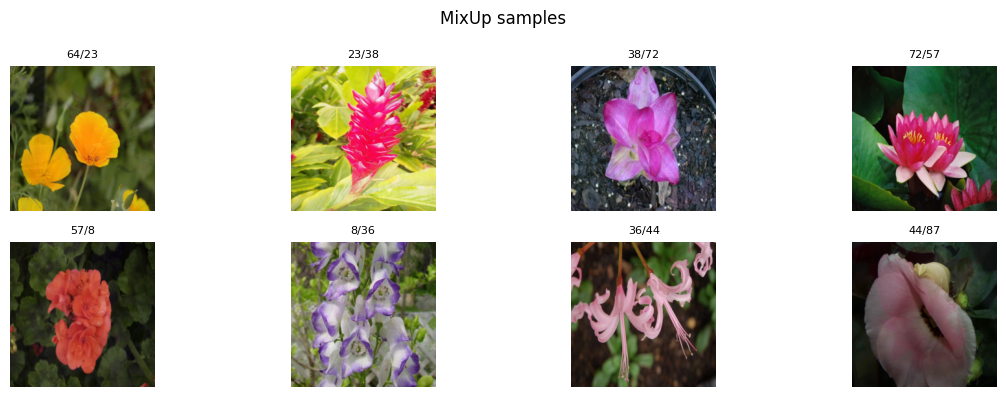

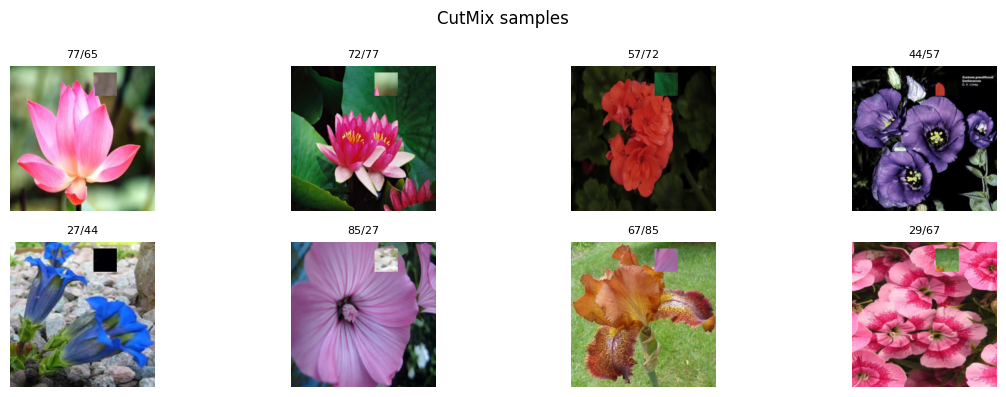

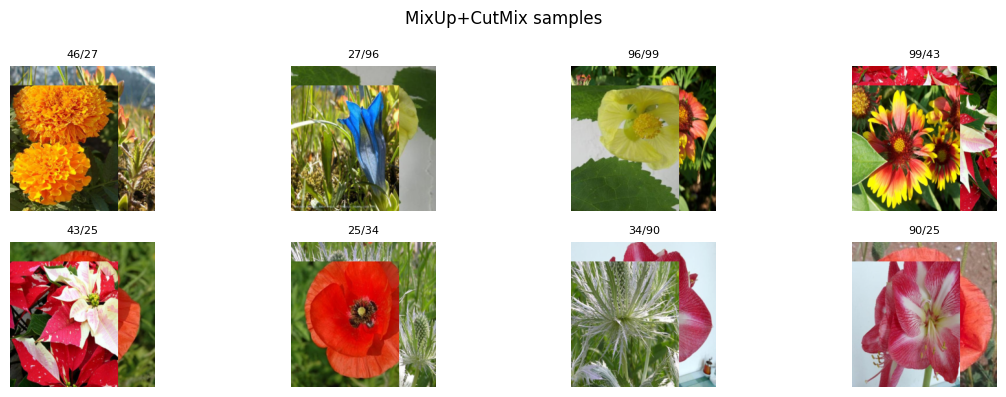

In [34]:
# Examples of MixUp and CutMix samples
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std  = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img = img * inv_std + inv_mean
    return np.clip(img, 0, 1)

def show_augmented_batch(loader, title, num_images=8):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 4))
    for i in range(min(num_images, images.size(0))):
        ax = plt.subplot(2, max(1, num_images // 2), i + 1)
        ax.imshow(denormalize(images[i]))
        if labels.ndim == 2:
            top2 = labels[i].topk(2)
            ax.set_title(f"{top2.indices[0].item()}/{top2.indices[1].item()}", fontsize=8)
        else:
            ax.set_title(str(labels[i].item()), fontsize=8)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_augmented_batch(train_loader_mixup, "MixUp samples")
show_augmented_batch(train_loader_cutmix, "CutMix samples")
show_augmented_batch(train_loader_mixupcutmix, "MixUp+CutMix samples")

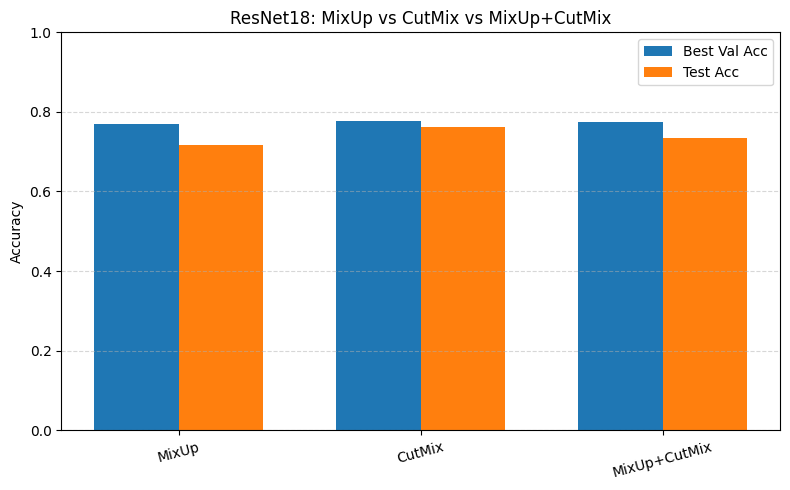

In [35]:
# Summary Bar Plots for Different Variants
variant_names = list(results.keys())
best_vals = [results[k]["best_val_acc"] for k in variant_names]
test_vals = [results[k]["test_acc"] for k in variant_names]

plt.figure(figsize=(8, 5))
x = np.arange(len(variant_names))
w = 0.35
plt.bar(x - w/2, best_vals, width=w, label="Best Val Acc")
plt.bar(x + w/2, test_vals, width=w, label="Test Acc")
plt.xticks(x, variant_names, rotation=15)
plt.ylim(0.0, 1.0)
plt.ylabel("Accuracy")
plt.title("ResNet18: MixUp vs CutMix vs MixUp+CutMix")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

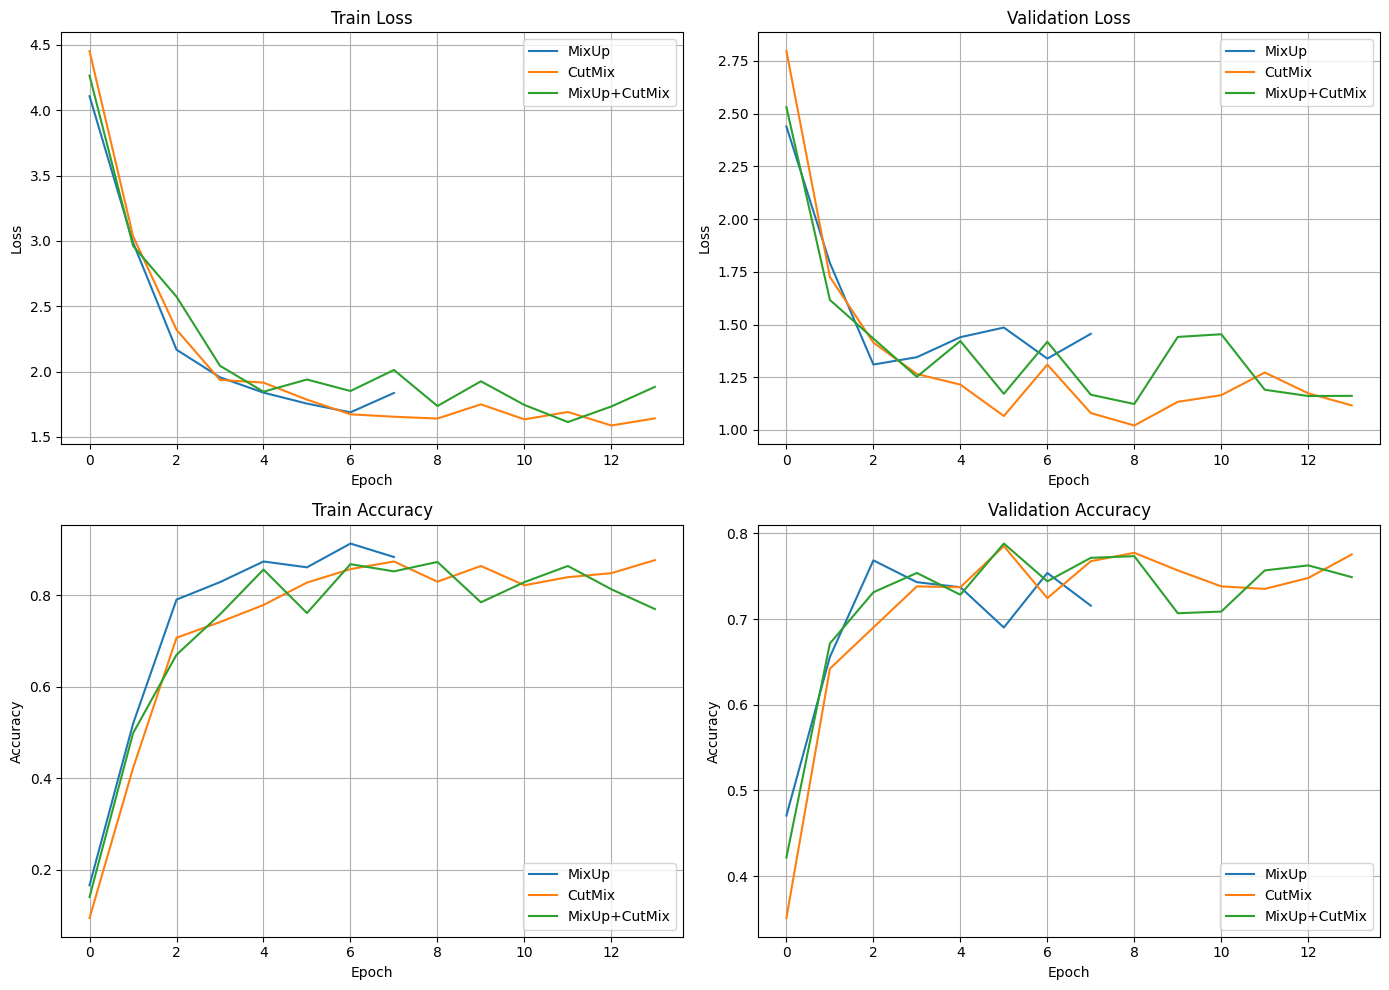

In [39]:
# Histories (All Variants)
plt.figure(figsize=(14, 10))

# Train Loss
ax1 = plt.subplot(2, 2, 1)
for name in variant_names:
    ax1.plot(results[name]["history"]["train_loss"], label=name)
ax1.set_title("Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Val Loss
ax2 = plt.subplot(2, 2, 2)
for name in variant_names:
    ax2.plot(results[name]["history"]["val_loss"], label=name)
ax2.set_title("Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train Acc
ax3 = plt.subplot(2, 2, 3)
for name in variant_names:
    ax3.plot(results[name]["history"]["train_acc"], label=name)
ax3.set_title("Train Accuracy")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Accuracy")
ax3.grid(True)
ax3.legend()

# Val Acc
ax4 = plt.subplot(2, 2, 4)
for name in variant_names:
    ax4.plot(results[name]["history"]["val_acc"], label=name)
ax4.set_title("Validation Accuracy")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Accuracy")
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()

Best variant by validation accuracy: CutMix


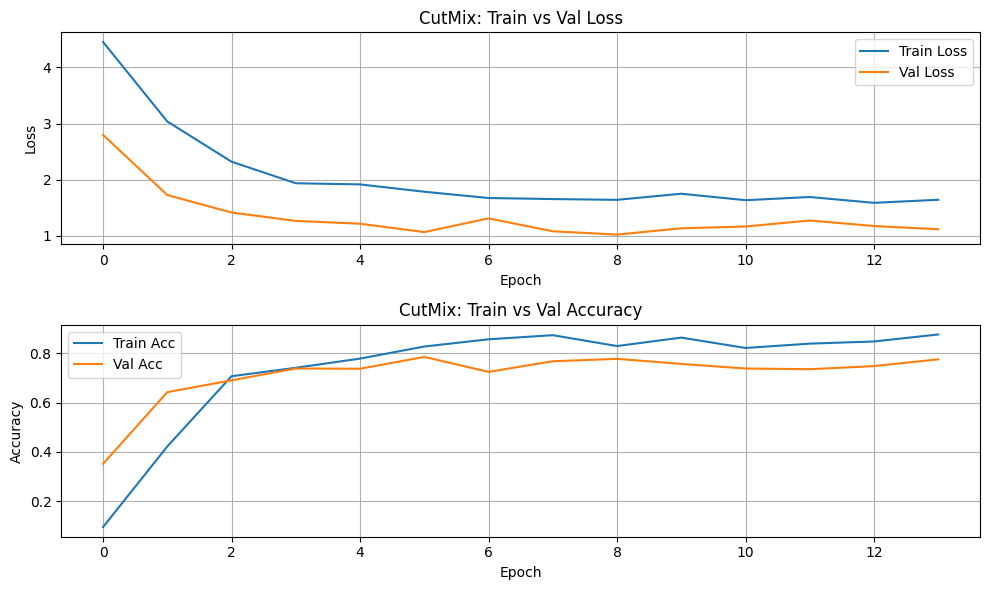

In [41]:
# Detailed history for best variant
best_variant = max(results.items(), key=lambda x: x[1]["best_val_acc"])[0]
print("Best variant by validation accuracy:", best_variant)

bv_hist = results[best_variant]["history"]

plt.figure(figsize=(10, 6))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(bv_hist["train_loss"], label="Train Loss")
ax1.plot(bv_hist["val_loss"], label="Val Loss")
ax1.set_title(f"{best_variant}: Train vs Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

ax2 = plt.subplot(2, 1, 2)
ax2.plot(bv_hist["train_acc"], label="Train Acc")
ax2.plot(bv_hist["val_acc"], label="Val Acc")
ax2.set_title(f"{best_variant}: Train vs Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()



In [45]:
# Calibration summary
print("\nCalibration (ECE) summary (best checkpoints):")
for name in variant_names:
    print(
        f"{name:12s} | "
        f"Val ECE: {results[name]['val_ece']:.4f} | "
        f"Test ECE: {results[name]['test_ece']:.4f}"
    )


Calibration (ECE) summary (best checkpoints):
MixUp        | Val ECE: 0.3147 | Test ECE: 0.3061
CutMix       | Val ECE: 0.1623 | Test ECE: 0.1769
MixUp+CutMix | Val ECE: 0.2233 | Test ECE: 0.2050
